# Unit-economics
## Определение прибыльности бизнеса

Unit-экономика - аналитический отчёт, который позволяет определить прибыльность одного юнита бизнеса - т.е. отдельного продукта, одного клиента или канала трафика.

Были выгружены логи пользователей, взаимодействовавших с интернет магазином. 
Доступна информация о совершенном дйствии, сумма покупки, идентификатор пользователя, 
канал привлечения ользователя и стоимость рекламной компании.

#### Основные показатели

#### Начало работы

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio # на случай, если юпитер резко перестает отображать графики plotly + pio.renderers.default = 'iframe'

logs = pd.read_excel('data.xlsx', sheet_name='logs')
users = pd.read_excel('data.xlsx', sheet_name='users')
print(logs.head(4), users.head(4), sep = '\n\n')

    ID       Дата Тип события  Сумма покупки
0  256 2019-01-02   Посещение            NaN
1  256 2019-01-04   Посещение            NaN
2  256 2019-01-04     Покупка         1698.0
3  268 2019-01-03   Посещение            NaN

   ID               Источник       Регион  Стоимость привлечения
0   1  Seo-продвижение сайта  г. Владимир                    431
1   2   Рекламное объявление  г. Владимир                    338
2   3                    Smm  г. Владимир                    546
3   4                    Smm  г. Владимир                    574


In [108]:
User = users['ID'].nunique() # количество привлекаемых пользователей
Custom = logs['ID'].nunique() # количество пользователей, посетивших сайт
Client = logs[logs['Тип события']=='Покупка']['ID'].nunique() # количество пользователей, совершивших покупку

data = {'Type': ['Users','Customers','Clients'], 'Number': [User, Custom, Client]} 
f = pd.DataFrame(data) 
f

,Type,Number
0,Users,3910
1,Customers,3637
2,Clients,2497


Из 3910 привлекаемых пользователей, сайт посетили 3637, 2497 из которых совершили покупку.

In [34]:
round(Custom/User*100, 3) # первое горлышко воронки

93.018

In [109]:
# поскольку целью коммерческой компании является получение прибыли, целевое дейтсвие - покупка
conversion = round(Client/Custom*100, 3)   # конверсия этапа
win_rate = round(Client/User*100, 3) #конверсия воронки: win rate

In [123]:
pio.renderers.default = 'iframe'
fig = go.Figure(go.Funnel(x=f.Number, y=f.Type,textposition = "inside",textinfo = "value+percent initial"))
fig.update_layout(template="simple_white",
    autosize=False,
    width=900,
    height=500,
    title={
        'text': f"Win-rate {win_rate}%",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

#### Для удобства работы объединим две таблицы так, чтобы попала вся информация о пользователях

In [37]:
df = logs.merge(users, how='outer', on='ID')
first = logs[logs['Тип события']=='Посещение'][['ID','Дата']].groupby('ID').min().reset_index().rename(columns={'Дата':'Reg'})
df = df.merge(first, how='left', on='ID')
df

,ID,Дата,Тип события,Сумма покупки,Источник,Регион,Стоимость привлечения,Reg
0,256,2019-01-02,Посещение,NaN,Контекстная реклама,г. Москва,495,2019-01-02
1,256,2019-01-04,Посещение,NaN,Контекстная реклама,г. Москва,495,2019-01-02
2,256,2019-01-04,Покупка,1698.0,Контекстная реклама,г. Москва,495,2019-01-02
3,256,2019-01-13,Посещение,NaN,Контекстная реклама,г. Москва,495,2019-01-02
4,256,2019-01-13,Покупка,1936.0,Контекстная реклама,г. Москва,495,2019-01-02
...,...,...,...,...,...,...,...,...
36043,3882,NaT,NaN,NaN,Seo-продвижение сайта,г. Санкт-Петербург,415,NaT
36044,3883,NaT,NaN,NaN,Seo-продвижение сайта,г. Волгоград,427,NaT
36045,3886,NaT,NaN,NaN,Контекстная реклама,г. Москва,407,NaT
36046,3890,NaT,NaN,NaN,Рекламное объявление,г. Орел,330,NaT


# Когортный анализ

Когортный анализ — это метод маркетингового исследования поведения пользователей, объединенных в когорты (группы) на основании действий, выполненных за определенный период. Такой подход позволяет подобрать ключевые метрики для каждой аудитории и увидеть эффективность продвижения бизнеса и маркетинговых кампаний.

In [38]:
t = df[df['Тип события']=='Покупка'].groupby([pd.Grouper(key='Reg', freq='w'), pd.Grouper(key='Дата', freq='w')]).agg({'ID':'nunique'}).reset_index()
t['ComebackWeek'] = (t['Дата']-t['Reg']).apply(lambda x: round(x/pd.Timedelta(1, 'w'),0))
#t = t.groupby([pd.Grouper(key='Reg', freq='w'), 'ComebackWeek']).agg({'ID':'sum'})

cohort = pd.pivot_table(t, index='Reg', columns='ComebackWeek', values='ID', aggfunc='sum')

attd =  df[df['Тип события']=='Посещение'].groupby(pd.Grouper(key='Reg', freq='w')).agg({'ID':'nunique'})
cohort.insert(0, 'CohortSize', attd)

cohort

ComebackWeek,CohortSize,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Reg,,,,,,,,,,,
2019-01-06,396,208.0,106.0,54.0,29.0,20.0,22.0,18.0,12.0,10.0,6.0
2019-01-13,467,273.0,137.0,58.0,36.0,33.0,25.0,27.0,13.0,1.0,NaN
2019-01-20,337,182.0,88.0,40.0,27.0,21.0,18.0,18.0,2.0,NaN,NaN
2019-01-27,352,222.0,88.0,41.0,31.0,26.0,22.0,6.0,NaN,NaN,NaN
2019-02-03,500,271.0,127.0,54.0,51.0,34.0,8.0,NaN,NaN,NaN,NaN
2019-02-10,549,286.0,147.0,71.0,53.0,9.0,NaN,NaN,NaN,NaN,NaN
2019-02-17,294,174.0,79.0,40.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-24,409,228.0,101.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,325,172.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
#Доли покупателей, основанные на данных когорт (еженедельная конверсия привлечённых клиентов)
Conv = cohort.apply(lambda x: x/attd['ID'])
Conv

ComebackWeek,CohortSize,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Reg,,,,,,,,,,,
2019-01-06,1.0,0.525253,0.267677,0.136364,0.073232,0.050505,0.055556,0.045455,0.030303,0.025253,0.015152
2019-01-13,1.0,0.584582,0.293362,0.124197,0.077088,0.070664,0.053533,0.057816,0.027837,0.002141,NaN
2019-01-20,1.0,0.540059,0.261128,0.118694,0.080119,0.062315,0.053412,0.053412,0.005935,NaN,NaN
2019-01-27,1.0,0.630682,0.250000,0.116477,0.088068,0.073864,0.062500,0.017045,NaN,NaN,NaN
2019-02-03,1.0,0.542000,0.254000,0.108000,0.102000,0.068000,0.016000,NaN,NaN,NaN,NaN
2019-02-10,1.0,0.520947,0.267760,0.129326,0.096539,0.016393,NaN,NaN,NaN,NaN,NaN
2019-02-17,1.0,0.591837,0.268707,0.136054,0.047619,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-24,1.0,0.557457,0.246944,0.051345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,1.0,0.529231,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


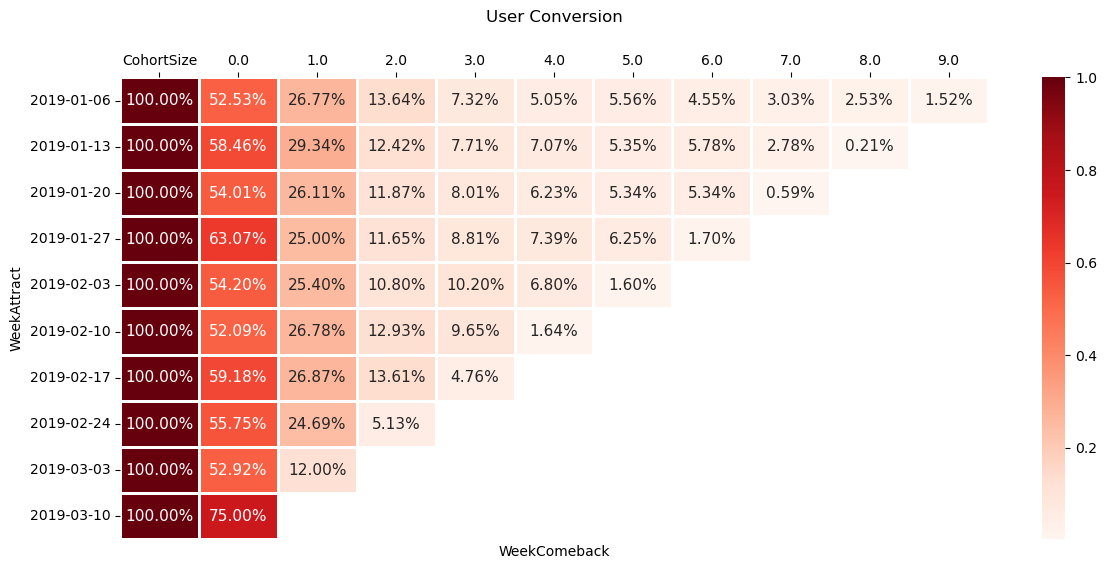

In [40]:
plt.figure(figsize=(14, 6))
ax = sns.heatmap(Conv, annot=True,
                   annot_kws={'size':'11'}, fmt='.2%', linewidths=1, square=False, cmap='Reds',
                   yticklabels=Conv.reset_index()['Reg'].dt.date) 
ax.xaxis.tick_top()
plt.xlabel('WeekComeback')
plt.ylabel('WeekAttract')
plt.title('User Conversion',pad=40)
plt.yticks(rotation = 0)
plt.show()

# Оценка проводимых рекламных компаний

In [41]:
costs = df.groupby('ID').agg({'Источник':'min', 'Стоимость привлечения':'min','Сумма покупки':'sum'}).reset_index()

# Общие затраты на привлечение пользователей
costs_t = costs.groupby('Источник').agg({'ID':'nunique', 'Стоимость привлечения':'sum'})\
                .rename(columns={'ID':'Кол-во привлекаемых пользователей', 'Стоимость привлечения':'total_costs'})

# Затраты на привлечение платящих пользователей
costs_p = costs[costs['Сумма покупки']!=0].groupby('Источник')\
                                .agg({'ID':'nunique', 'Стоимость привлечения':'sum', 'Сумма покупки':'sum'})\
                                .rename(columns={'ID':'Кол-во платящих пользователей', 'Стоимость привлечения':'pay_costs','Сумма покупки':'Выручка'})

costs_piv = costs_t.merge(costs_p, how='left', on='Источник')
costs_piv['ARPU'] = costs_piv['Выручка']/costs_piv['Кол-во привлекаемых пользователей']
costs_piv['ARPPU'] = costs_piv['Выручка']/costs_piv['Кол-во платящих пользователей']
costs_piv['Conversion'] = round(costs_piv['Кол-во платящих пользователей']/costs_piv['Кол-во привлекаемых пользователей']*100,2)
costs_piv['CPA'] = round(costs_piv['total_costs']/costs_piv['Кол-во привлекаемых пользователей'],2)
costs_piv

,Кол-во привлекаемых пользователей,total_costs,Кол-во платящих пользователей,pay_costs,Выручка,ARPU,ARPPU,Conversion,CPA
Источник,,,,,,,,,
Seo-продвижение сайта,1016,463688,665,304671,1739273.0,1711.882874,2615.448120,65.45,456.39
Smm,1014,466691,641,294045,1169992.0,1153.838264,1825.260530,63.21,460.25
Контекстная реклама,958,440756,611,282719,1564900.0,1633.507307,2561.211129,63.78,460.08
Рекламное объявление,922,425466,580,266082,1305227.0,1415.647505,2250.391379,62.91,461.46


Наиболее эффективной оказалось Seo-продвижение сайта, причем по 4м показателям: ARPU, ARPPU, Conversion, CPA.  
Наименее эффективная - рекламное объявление.  
Наименее прибыльное - SMM.


In [42]:
#привлечённые пользователи(зашедшие на сайт) по неделям
pl = first.merge(users, how='left', on='ID') #уникальные пользователи - дата и стоимость привлечения
t = pl.groupby([pd.Grouper(key='Reg', freq='w'), 'Источник']).nunique().reset_index()
priv_c = pd.pivot_table(t, index='Источник', columns='Reg', values='ID', margins=True, aggfunc=sum)
priv_c

Reg,2019-01-06 00:00:00,2019-01-13 00:00:00,2019-01-20 00:00:00,2019-01-27 00:00:00,2019-02-03 00:00:00,2019-02-10 00:00:00,2019-02-17 00:00:00,2019-02-24 00:00:00,2019-03-03 00:00:00,2019-03-10 00:00:00,All
Источник,,,,,,,,,,,
Seo-продвижение сайта,107,127,80,102,120,160,80,105,70,1,952
Smm,90,121,84,81,136,135,89,109,92,1,938
Контекстная реклама,102,114,94,90,138,133,52,90,84,3,900
Рекламное объявление,97,105,79,79,106,121,73,105,79,3,847
All,396,467,337,352,500,549,294,409,325,8,3637


In [43]:
#затраты на привлечение пользователей, совершивших посещение
t = pl.groupby([pd.Grouper(key='Reg', freq='w'), 'Источник'])['Стоимость привлечения'].sum().reset_index()
priv_z =pd.pivot_table(t, index='Источник', columns='Reg', values='Стоимость привлечения', margins=True, aggfunc=sum)
priv_z

Reg,2019-01-06 00:00:00,2019-01-13 00:00:00,2019-01-20 00:00:00,2019-01-27 00:00:00,2019-02-03 00:00:00,2019-02-10 00:00:00,2019-02-17 00:00:00,2019-02-24 00:00:00,2019-03-03 00:00:00,2019-03-10 00:00:00,All
Источник,,,,,,,,,,,
Seo-продвижение сайта,49245,57761,35602,46185,56576,71687,37561,47623,31434,593,434267
Smm,42709,55650,39803,37157,62050,61800,40985,48793,41889,600,431436
Контекстная реклама,48295,51911,44198,41741,63822,60313,23447,40742,37700,1495,413664
Рекламное объявление,43488,48435,36506,36004,50257,56670,33939,48395,37657,1348,392699
All,183737,213757,156109,161087,232705,250470,135932,185553,148680,4036,1672066


#### Стоимость одного привлечения

In [44]:
print(f'Стоимость одного привлечения {round(priv_z.iloc[4,10]/priv_c.iloc[4,10],3)}')

Стоимость одного привлечения 459.738


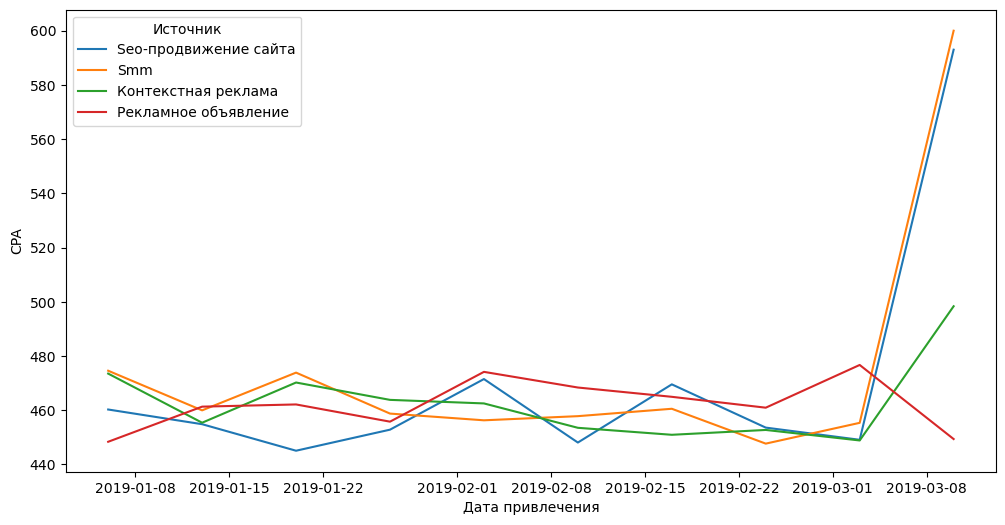

In [45]:
a = pl.groupby([pd.Grouper(key='Reg', freq='w'), 'Источник']).agg({'Стоимость привлечения':'sum', 'ID':'nunique'}).reset_index()
a['CPA'] = a['Стоимость привлечения']/a['ID']
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=a, x="Reg", y="CPA", hue="Источник")
plt.xlabel('Дата привлечения')
plt.show()

In [46]:
#доходы по дате регистрации (чтобы по дате покупки поменять Reg на Дата)
buy = df[df['Тип события']=='Покупка'].groupby([pd.Grouper(key='Reg', freq='w'), 'Источник']).agg({ 'Сумма покупки':'sum'}).reset_index()
pd.pivot_table(buy, index='Источник', columns='Reg', values='Сумма покупки', margins=True, aggfunc='sum')

Reg,2019-01-06 00:00:00,2019-01-13 00:00:00,2019-01-20 00:00:00,2019-01-27 00:00:00,2019-02-03 00:00:00,2019-02-10 00:00:00,2019-02-17 00:00:00,2019-02-24 00:00:00,2019-03-03 00:00:00,2019-03-10 00:00:00,All
Источник,,,,,,,,,,,
Seo-продвижение сайта,177183.0,297616.0,146678.0,220215.0,230708.0,259851.0,175549.0,154994.0,75243.0,1236.0,1739273.0
Smm,145723.0,149820.0,112884.0,105607.0,177948.0,187863.0,135010.0,87400.0,67326.0,411.0,1169992.0
Контекстная реклама,238757.0,188418.0,181123.0,153312.0,260069.0,244820.0,84446.0,123972.0,87187.0,2796.0,1564900.0
Рекламное объявление,151479.0,231061.0,139057.0,132432.0,163171.0,192222.0,82847.0,149528.0,61440.0,1990.0,1305227.0
All,713142.0,866915.0,579742.0,611566.0,831896.0,884756.0,477852.0,515894.0,291196.0,6433.0,5779392.0


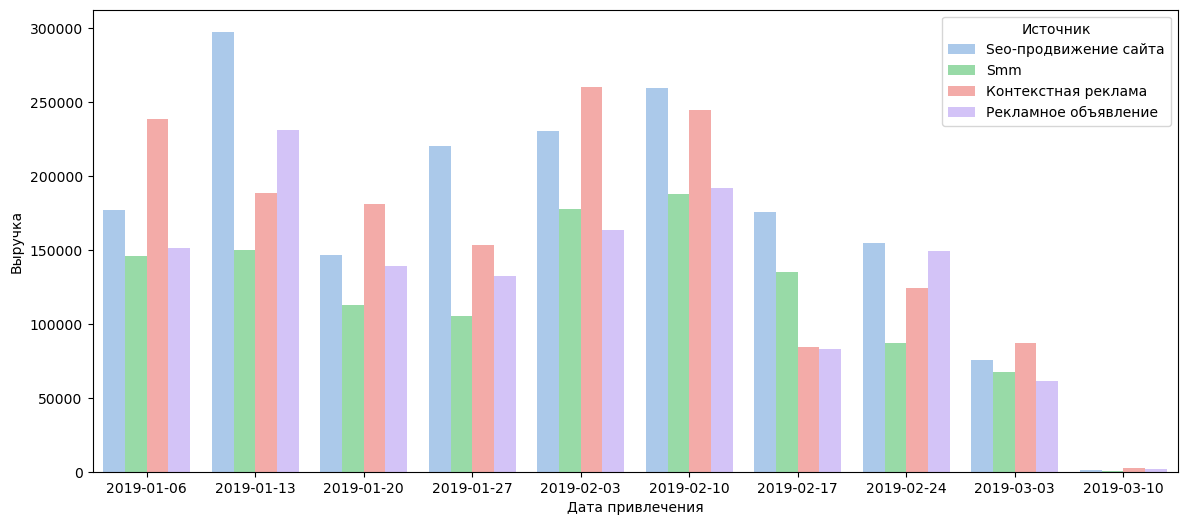

In [47]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(x = buy['Reg'].dt.date, y = buy['Сумма покупки'], hue = buy['Источник'], palette='pastel6')
plt.ylabel('Выручка')
plt.xlabel('Дата привлечения')
plt.show()
# можно выяснить связана ли сумма покупки и канал продвижения

# Основные показатели юнит-экономики по неделям

UniqueUsers	Уникальные пользователи  
TotalOrders	Количество заказов  
UniqueCustomers	Уникальные покупатели   
OrdersPerCustomer	Заказы на покупателей  
CoeffConversion	Коэффициент конверсии  
Revenue	Доход  
ARPC	Средний чек  
ARPPU	Доход на покупателя  
AcquisitionCosts	Стоимость привлечения  
Income	Прибыль	

In [48]:
his = df
r = his[his['Тип события']=='Посещение'].groupby(pd.Grouper(key='Дата', freq='w')).agg({'ID':'nunique'})
r.columns = ['UniqueUsers']
r['TotalOrders'] = his[his['Тип события']=='Покупка'].groupby(pd.Grouper(key='Дата', freq='w')).agg({'Тип события':'count'})
r['UniqueCustomers'] = his[his['Тип события']=='Покупка'].groupby(pd.Grouper(key='Дата', freq='w')).agg({'ID':'nunique'})
r['OrdersPerCustomer'] = r['TotalOrders']/r['UniqueCustomers']
r['CoeffConversion'] = r['UniqueCustomers']/r['UniqueUsers']
r['Revenue'] = his[his['Тип события']=='Покупка'].groupby(pd.Grouper(key='Дата', freq='w')).agg({'Сумма покупки':'sum'})
r['ARPC'] = r['Revenue']/r['TotalOrders']
r['ARPPU'] = r['Revenue']/r['UniqueCustomers']
r['AcquisitionCosts'] = pl.groupby(pd.Grouper(key='Reg',freq='w')).agg({'Стоимость привлечения':'sum'})
r['Income'] = r['Revenue'] - r['AcquisitionCosts'] 

r.round(2)

,UniqueUsers,TotalOrders,UniqueCustomers,OrdersPerCustomer,CoeffConversion,Revenue,ARPC,ARPPU,AcquisitionCosts,Income
Дата,,,,,,,,,,
2019-01-06,396,316,208,1.52,0.53,309677.0,979.99,1488.83,183737,125940.0
2019-01-13,735,555,379,1.46,0.52,548370.0,988.05,1446.89,213757,334613.0
2019-01-20,737,559,373,1.50,0.51,541833.0,969.29,1452.64,156109,385724.0
2019-01-27,730,568,397,1.43,0.54,544032.0,957.80,1370.36,161087,382945.0
2019-02-03,913,649,455,1.43,0.50,640819.0,987.39,1408.39,232705,408114.0
2019-02-10,1086,829,536,1.55,0.49,815951.0,984.26,1522.30,250470,565481.0
2019-02-17,923,760,470,1.62,0.51,752573.0,990.23,1601.22,135932,616641.0
2019-02-24,958,797,512,1.56,0.53,785523.0,985.60,1534.22,185553,599970.0
2019-03-03,930,724,463,1.56,0.50,716999.0,990.33,1548.59,148680,568319.0


# Показатели юнит-экономики по регионам присутствия

In [96]:
# подготовка геоданных
data = {'Регион': ['г. Владимир', 'г. Волгоград','г. Екатеринбург','г. Москва','г. Орел','г. Санкт-Петербург'], 
        'latitude': ['56.14','48.72','56.85','55.75','52.97','59.94'], 'longtitude': ['40.4','44.5','60.61','37.62','36.08','30.31']} 
g = pd.DataFrame(data) 
g

,Регион,latitude,longtitude
0,г. Владимир,56.14,40.4
1,г. Волгоград,48.72,44.5
2,г. Екатеринбург,56.85,60.61
3,г. Москва,55.75,37.62
4,г. Орел,52.97,36.08
5,г. Санкт-Петербург,59.94,30.31


In [102]:
# unit-economics
r = his[his['Тип события']=='Посещение'].groupby('Регион').agg({'ID':'nunique'})
r.columns = ['UniqueUsers']
r['TotalOrders'] = his[his['Тип события']=='Покупка'].groupby('Регион').agg({'Тип события':'count'})
r['UniqueCustomers'] = his[his['Тип события']=='Покупка'].groupby('Регион').agg({'ID':'nunique'})
r['OrdersPerCustomer'] = r['TotalOrders']/r['UniqueCustomers']
r['CoeffConversion'] = r['UniqueCustomers']/r['UniqueUsers']
r['Revenue'] = his[his['Тип события']=='Покупка'].groupby('Регион').agg({'Сумма покупки':'sum'})
r['ARPC'] = r['Revenue']/r['TotalOrders']
r['ARPPU'] = r['Revenue']/r['UniqueCustomers']
r['AcquisitionCosts'] = pl.groupby('Регион').agg({'Стоимость привлечения':'sum'})
r['Income'] = r['Revenue'] - r['AcquisitionCosts']

r = r.merge(g, how='left', on='Регион')

r.round(2)


,Регион,UniqueUsers,TotalOrders,UniqueCustomers,OrdersPerCustomer,CoeffConversion,Revenue,ARPC,ARPPU,AcquisitionCosts,Income,latitude,longtitude
0,г. Владимир,577,961,400,2.40,0.69,792861.0,825.04,1982.15,266632,526229.0,56.14,40.4
1,г. Волгоград,636,1054,456,2.31,0.72,962965.0,913.63,2111.77,289336,673629.0,48.72,44.5
2,г. Екатеринбург,562,909,381,2.39,0.68,906260.0,996.99,2378.64,261429,644831.0,56.85,60.61
3,г. Москва,596,935,405,2.31,0.68,1192169.0,1275.05,2943.63,275700,916469.0,55.75,37.62
4,г. Орел,638,983,429,2.29,0.67,714112.0,726.46,1664.60,289279,424833.0,52.97,36.08
5,г. Санкт-Петербург,628,1036,426,2.43,0.68,1211025.0,1168.94,2842.78,289690,921335.0,59.94,30.31


In [125]:
pio.renderers.default = 'iframe'
fig = px.scatter_geo(r, lat='latitude', lon='longtitude', color='Регион',
                     hover_name='Регион', size='Income', size_max=20, opacity=0.8)  
fig.show()

Как мы видим, наибольшую прибыль мы получаем от продаж в г. Санкт-Петербург, но при этом средний чек и доход на одного покупателя выше в Москве. Стоит отметить, что наибольшая конверсия в г. Волгоград.

# Показатели, характеризующие эффективность привлечения по когортам

AttrUsers	Привлечённые клиенты  
AttrCustomers	Привлечённые покупатели  
Retention	Вернувшиеся клиенты  
Churn	Не вернувшиеся клиенты  
RR	Retention Rate  
CR	Churn Rate  
AttrCost	Стоимость привлечения  
CPA	Стоимость привлечения одного клиента  
Conversion	Конверсия в покупку  
CPC	Стоимость привлечения одного покупателя  
Revenue	Доход  
ARPU	Средний доход с клиента  
ARPPU	Средний доход с покупателя  
ROI	Коэффиициент окупаемости инвестиций	

In [49]:
lf = logs.merge(first, how='left', on='ID')
lf['Size'] = lf.groupby(by = "ID").transform('size')
r = his[his['Тип события']=='Посещение'].groupby(pd.Grouper(key='Reg', freq='w')).agg({'ID':'nunique'})
r.columns = ['AttrUsers']
r['AttrCustomers'] = his[his['Тип события']=='Покупка'].groupby(pd.Grouper(key='Reg', freq='w')).agg({'ID':'nunique'})
r['Retention'] = lf[lf.Size > 1].groupby(pd.Grouper(key = 'Reg', freq = 'W'))['ID'].nunique()
r['Churn'] = r['AttrUsers'] - r['Retention']
r['RR'] = r['Retention']/r['AttrUsers']
r['CR'] = 1 - r['RR']
r['AttrCosts'] = pl.groupby(pd.Grouper(key='Reg',freq='w')).agg({'Стоимость привлечения':'sum'})
r['CPA'] = r['AttrCosts']/r['AttrUsers']
r['Conversion'] = r['AttrCustomers']/r['AttrUsers']
r['CPC'] = r['AttrCosts']/r['AttrCustomers']
r['Revenue'] = his[his['Тип события']=='Покупка'].groupby(pd.Grouper(key='Reg', freq='w')).agg({'Сумма покупки':'sum'})
r['ARPU'] = r['Revenue']/r['AttrUsers']
r['ARPPU'] = r['Revenue']/r['AttrCustomers']
r['ROI'] = (r['Revenue'] - r['AttrCosts'])/r['AttrCosts'] *100
r.round(2)

,AttrUsers,AttrCustomers,Retention,Churn,RR,CR,AttrCosts,CPA,Conversion,CPC,Revenue,ARPU,ARPPU,ROI
Reg,,,,,,,,,,,,,,
2019-01-06,396,270,375,21,0.95,0.05,183737,463.98,0.68,680.51,713142.0,1800.86,2641.27,288.13
2019-01-13,467,343,441,26,0.94,0.06,213757,457.72,0.73,623.20,866915.0,1856.35,2527.45,305.56
2019-01-20,337,233,314,23,0.93,0.07,156109,463.23,0.69,670.00,579742.0,1720.30,2488.16,271.37
2019-01-27,352,266,341,11,0.97,0.03,161087,457.63,0.76,605.59,611566.0,1737.40,2299.12,279.65
2019-02-03,500,346,474,26,0.95,0.05,232705,465.41,0.69,672.56,831896.0,1663.79,2404.32,257.49
2019-02-10,549,366,515,34,0.94,0.06,250470,456.23,0.67,684.34,884756.0,1611.58,2417.37,253.24
2019-02-17,294,205,279,15,0.95,0.05,135932,462.35,0.70,663.08,477852.0,1625.35,2330.99,251.54
2019-02-24,409,275,380,29,0.93,0.07,185553,453.67,0.67,674.74,515894.0,1261.35,1875.98,178.03
2019-03-03,325,187,294,31,0.90,0.10,148680,457.48,0.58,795.08,291196.0,895.99,1557.20,95.85


# С учетом регионов

In [126]:
# unit-economics
r = his[his['Тип события']=='Посещение'].groupby([pd.Grouper(key='Дата', freq='w'), 'Регион']).agg({'ID':'nunique'})
r.columns = ['UniqueUsers']
r['TotalOrders'] = his[his['Тип события']=='Покупка'].groupby([pd.Grouper(key='Дата', freq='w'), 'Регион'])\
                                                        .agg({'Тип события':'count'})
r['UniqueCustomers'] = his[his['Тип события']=='Покупка'].groupby([pd.Grouper(key='Дата', freq='w'), 'Регион'])\
                                                        .agg({'ID':'nunique'})
r['OrdersPerCustomer'] = r['TotalOrders']/r['UniqueCustomers']
r['CoeffConversion'] = r['UniqueCustomers']/r['UniqueUsers']
r['Revenue'] = his[his['Тип события']=='Покупка'].groupby([pd.Grouper(key='Дата', freq='w'), 'Регион'])\
                                                        .agg({'Сумма покупки':'sum'})
r['ARPC'] = r['Revenue']/r['TotalOrders']
r['ARPPU'] = r['Revenue']/r['UniqueCustomers']
r['AcquisitionCosts'] = pl.groupby([pd.Grouper(key='Reg', freq='w'), 'Регион']).agg({'Стоимость привлечения':'sum'})
r['Income'] = r['Revenue'] - r['AcquisitionCosts'] 

#r['Регион']
r.round(2)

UniqueUsers  TotalOrders  UniqueCustomers  \
Дата       Регион                                                          
2019-01-06 г. Владимир                  63           56               35   
           г. Волгоград                 67           54               37   
           г. Екатеринбург              71           64               39   
           г. Москва                    70           55               34   
           г. Орел                      50           33               25   
           г. Санкт-Петербург           75           54               38   
2019-01-13 г. Владимир                 116           80               60   
           г. Волгоград                124           90               61   
           г. Екатеринбург             124           78               53   
           г. Москва                   119           84               59   
           г. Орел                     129          120               81   
           г. Санкт-Петербург          123          103               65   
2019-01-20 г. Владимир                 101           73               48   
           г. Волгоград                129          103               65   
           г. Екатеринбург             126           87               61   
           г. Москва                   112           94               63   
           г. Орел                     129           98               64   
           г. Санкт-Петербург          140          104               72   
2019-01-27 г. Владимир                 111           92               65   
           г. Волгоград                137          112               78   
           г. Екатеринбург             107           77               55   
           г. Москва                   100           73               56   
           г. Орел                     126           92               59   
           г. Санкт-Петербург          149          122               84   
2019-02-03 г. Владимир                 161          126               83   
           г. Волгоград                166          129               97   
           г. Екатеринбург             127           99               68   
           г. Москва                   136           88               60   
           г. Орел                     146           90               68   
           г. Санкт-Петербург          177          117               79   
2019-02-10 г. Владимир                 190          145               86   
           г. Волгоград                182          149               99   
           г. Екатеринбург             164          102               79   
           г. Москва                   164          129               85   
           г. Орел                     189          145               90   
           г. Санкт-Петербург          197          159               97   
2019-02-17 г. Владимир                 149          118               73   
           г. Волгоград                153          131               87   
           г. Екатеринбург             153          132               78   
           г. Москва                   146          137               82   
           г. Орел                     167          121               77   
           г. Санкт-Петербург          155          121               73   
2019-02-24 г. Владимир                 151          131               81   
           г. Волгоград                164          132               87   
           г. Екатеринбург             161          135               91   
           г. Москва                   169          133               85   
           г. Орел                     165          139               88   
           г. Санкт-Петербург          148          127               80   
2019-03-03 г. Владимир                 159          121               83   
           г. Волгоград                158          137               85   
           г. Екатеринбург             143          112               68   
   

03/10 19 самостоятельных (т.е. без затрат на привлечение) клиентов совершили покупку в г. Владимир. В первый день компаний в Орле работа была убыточной.

In [127]:
# эффективность привлечения
lf = logs.merge(first, how='left', on='ID')
lf['Size'] = lf.groupby(by = "ID").transform('size')
r = his[his['Тип события']=='Посещение'].groupby([pd.Grouper(key='Reg', freq='w'), 'Регион']).agg({'ID':'nunique'})
r.columns = ['AttrUsers']
r['AttrCustomers'] = his[his['Тип события']=='Покупка'].groupby([pd.Grouper(key='Reg', freq='w'), 'Регион']).agg({'ID':'nunique'})
lf = lf.merge(users, how='left', on='ID')
r['Retention'] = lf[lf.Size > 1].groupby([pd.Grouper(key='Reg', freq='w'), 'Регион'])['ID'].nunique()
r['Churn'] = r['AttrUsers'] - r['Retention']
r['RR'] = r['Retention']/r['AttrUsers']
r['CR'] = 1 - r['RR']
r['AttrCosts'] = pl.groupby([pd.Grouper(key='Reg', freq='w'), 'Регион']).agg({'Стоимость привлечения':'sum'})
r['CPA'] = r['AttrCosts']/r['AttrUsers']
r['Conversion'] = r['AttrCustomers']/r['AttrUsers']
r['CPC'] = r['AttrCosts']/r['AttrCustomers']
r['Revenue'] = his[his['Тип события']=='Покупка'].groupby([pd.Grouper(key='Reg', freq='w'), 'Регион']).agg({'Сумма покупки':'sum'})
r['ARPU'] = r['Revenue']/r['AttrUsers']
r['ARPPU'] = r['Revenue']/r['AttrCustomers']
r['ROI'] = (r['Revenue'] - r['AttrCosts'])/r['AttrCosts'] *100
r.round(2).fillna(0)

AttrUsers  AttrCustomers  Retention  Churn  \
Reg        Регион                                                           
2019-01-06 г. Владимир                63           44.0       57.0    6.0   
           г. Волгоград               67           49.0       65.0    2.0   
           г. Екатеринбург            71           48.0       68.0    3.0   
           г. Москва                  70           49.0       69.0    1.0   
           г. Орел                    50           33.0       47.0    3.0   
           г. Санкт-Петербург         75           47.0       69.0    6.0   
2019-01-13 г. Владимир                70           53.0       67.0    3.0   
           г. Волгоград               81           57.0       78.0    3.0   
           г. Екатеринбург            74           50.0       67.0    7.0   
           г. Москва                  67           45.0       63.0    4.0   
           г. Орел                   100           79.0       96.0    4.0   
           г. Санкт-Петербург         75           59.0       70.0    5.0   
2019-01-20 г. Владимир                37           26.0       35.0    2.0   
           г. Волгоград               64           46.0       60.0    4.0   
           г. Екатеринбург            58           40.0       58.0    0.0   
           г. Москва                  43           32.0       38.0    5.0   
           г. Орел                    59           37.0       52.0    7.0   
           г. Санкт-Петербург         76           52.0       71.0    5.0   
2019-01-27 г. Владимир                55           43.0       54.0    1.0   
           г. Волгоград               72           59.0       70.0    2.0   
           г. Екатеринбург            50           37.0       48.0    2.0   
           г. Москва                  51           44.0       49.0    2.0   
           г. Орел                    59           37.0       56.0    3.0   
           г. Санкт-Петербург         65           46.0       64.0    1.0   
2019-02-03 г. Владимир                90           63.0       85.0    5.0   
           г. Волгоград               96           72.0       92.0    4.0   
           г. Екатеринбург            69           47.0       66.0    3.0   
           г. Москва                  79           52.0       72.0    7.0   
           г. Орел                    77           52.0       72.0    5.0   
           г. Санкт-Петербург         89           60.0       87.0    2.0   
2019-02-10 г. Владимир                99           67.0       91.0    8.0   
           г. Волгоград               83           57.0       78.0    5.0   
           г. Екатеринбург            83           51.0       75.0    8.0   
           г. Москва                  93           64.0       89.0    4.0   
           г. Орел                   104           68.0      100.0    4.0   
           г. Санкт-Петербург         87           59.0       82.0    5.0   
2019-02-17 г. Владимир                39           22.0       38.0    1.0   
           г. Волгоград               45           38.0       43.0    2.0   
           г. Екатеринбург            53           42.0       50.0    3.0   
           г. Москва                  59           38.0       57.0    2.0   
           г. Орел                    52           33.0       51.0    1.0   
           г. Санкт-Петербург         46           32.0       40.0    6.0   
2019-02-24 г. Владимир                63           45.0       59.0    4.0   
           г. Волгоград               73           47.0       69.0    4.0   
           г. Екатеринбург            66           46.0       63.0    3.0   
           г. Москва                  78           49.0       72.0    6.0   
           г. Орел                    73           51.0       66.0    7.0   
           г. Санкт-Петербург         56           37.0       51.0    5.0   
2019-03-03 г. Владимир                61           37.0       57.0    4.0   
           г. Волгоград               54           31.0       45.0    9.0   
           г. Екатеринбург 